In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import math
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC
import pandas as pd
import seaborn as sns
import random
import statistics  
from scipy import stats
import statsmodels.api as sm
from decimal import Decimal

# Task 1

Fill-in the missing values in the bank dataset. Use the EDA techniques from E-tivity 1 to decide how to fill in missing values. In your notebook, explain shortly (max 250 words) the decisions you have taken.

In [2]:
df = pd.read_csv('./bank_et2.csv')

In [3]:
df.head()

,Unnamed: 0,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,0,32.0,technician,single,tertiary,no,392,1.300134,0.473895,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,1,39.0,technician,divorced,secondary,no,688,-0.193701,0.237021,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,2,59.0,retired,married,secondary,no,1035,1.334266,0.121981,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,3,47.0,blue-collar,married,secondary,no,398,0.362286,1.251328,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,4,54.0,retired,married,secondary,no,1004,0.072075,-0.533738,yes,no,cellular,1,apr,479,1,307,1,failure,no


In [4]:
#Drop Unnamed column as it is just an index
df.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
# Find the number of nulls/NaNs in the dataset

df.apply(lambda x: sum(x.isnull()), axis=0)

age              12
job              10
marital           0
education       104
default           0
balance           0
ratio_bal_ln      0
ratio_ln_inc      0
housing           0
loan              0
contact         191
day               0
month             0
duration          0
campaign          0
pdays             0
previous          0
poutcome        454
subscribed        0
dtype: int64

Your selected dataframe has 19 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
poutcome,454,22.7
contact,191,9.6
education,104,5.2
age,12,0.6
job,10,0.5


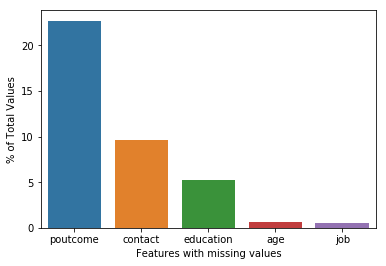

In [6]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        sns.barplot(x=mis_val_table_ren_columns.index, y=mis_val_table_ren_columns['% of Total Values'])
        plt.xlabel('Features with missing values')
        return mis_val_table_ren_columns

missing_values_table(df)

In [7]:
df['age'].describe()

count    1988.000000
mean       41.753018
std        12.724358
min        18.000000
25%        32.000000
50%        38.000000
75%        50.000000
max        93.000000
Name: age, dtype: float64

Since there are only 12 instances of age missing, **and mean value is not so far from the median (41/38)**, we can use the mean to replace the missing values

In [8]:
df['age'].fillna(df['age'].mean(), inplace=True)

Since Contact is nearly 92% filled with cellular, we can fill the missing values with cellular

In [9]:
df['contact'].value_counts()

cellular     1663
telephone     146
Name: contact, dtype: int64

In [10]:
df['contact'].fillna('cellular', inplace=True)


poutcome is the result of last campaign with each customer, and we are having 454 missing values for it :

In [11]:
df['poutcome'].value_counts()

failure    955
success    444
other      147
Name: poutcome, dtype: int64

We can explore some other features related to poutcome, like pdays which is number of days that passed after the customer was 
last contacted during a previous merketing campaign :

In [12]:
df['pdays'].describe()

count    2000.000000
mean      167.896000
std       131.754126
min        -1.000000
25%        75.750000
50%       182.000000
75%       251.000000
max       854.000000
Name: pdays, dtype: float64

Some values are negative for this feature which is not possible, unless this means that there was no previous campaign for the customer, let us see how many customers have negative value for pdays :

In [13]:
sum(df['pdays']<0)

454

Exactly same as missing values number for poutcome,this confirms that these are just costumers who didn't have any previous campaign, we will then impute missing poutcome with a category "no previous".

In [14]:
df['poutcome'].fillna('no_previous',inplace=True)

In [15]:
df['poutcome'].value_counts()

failure        955
no_previous    454
success        444
other          147
Name: poutcome, dtype: int64

Since there are only 10 missing values in job we can remove all rows that having missing values in the job column

In [16]:
df=df.dropna(subset=['job'])

In [17]:
df['education'].value_counts()

secondary    993
tertiary     683
primary      215
Name: education, dtype: int64

I used backfill to fill missing data in the education column, the backfill method fill the data with more or less then desired ratio of the 3 different values

In [41]:
df['education'].fillna(method='bfill',inplace=True)


In [42]:
df['education'].value_counts()

secondary    985
tertiary     665
primary      214
Name: education, dtype: int64

In [43]:
df.count()

age                     1864
job                     1864
marital                 1864
education               1864
balance                 1864
ratio_bal_ln            1864
ratio_ln_inc            1864
housing                 1864
loan                    1864
contact                 1864
day                     1864
month                   1864
duration                1864
campaign                1864
pdays                   1864
previous                1864
poutcome                1864
subscribed              1864
job_blue-collar         1864
job_no_active_income    1864
job_self-employed       1864
job_services            1864
job_student             1864
marital_married         1864
marital_single          1864
education_secondary     1864
education_tertiary      1864
housing_yes             1864
loan_yes                1864
contact_telephone       1864
month_Spring            1864
month_Summer            1864
month_Winter            1864
poutcome_no_previous    1864
poutcome_other

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 0 to 1999
Data columns (total 19 columns):
age             1990 non-null float64
job             1990 non-null object
marital         1990 non-null object
education       1990 non-null object
default         1990 non-null object
balance         1990 non-null int64
ratio_bal_ln    1990 non-null float64
ratio_ln_inc    1990 non-null float64
housing         1990 non-null object
loan            1990 non-null object
contact         1990 non-null object
day             1990 non-null int64
month           1990 non-null object
duration        1990 non-null int64
campaign        1990 non-null int64
pdays           1990 non-null int64
previous        1990 non-null int64
poutcome        1990 non-null object
subscribed      1990 non-null object
dtypes: float64(3), int64(6), object(10)
memory usage: 310.9+ KB


#### Finally we convert object feature to Category type

In [22]:
objects=df.select_dtypes(include='object')
for column in objects:
    df[column]=df[column].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 0 to 1999
Data columns (total 19 columns):
age             1990 non-null float64
job             1990 non-null category
marital         1990 non-null category
education       1990 non-null category
default         1990 non-null category
balance         1990 non-null int64
ratio_bal_ln    1990 non-null float64
ratio_ln_inc    1990 non-null float64
housing         1990 non-null category
loan            1990 non-null category
contact         1990 non-null category
day             1990 non-null int64
month           1990 non-null category
duration        1990 non-null int64
campaign        1990 non-null int64
pdays           1990 non-null int64
previous        1990 non-null int64
poutcome        1990 non-null category
subscribed      1990 non-null category
dtypes: category(10), float64(3), int64(6)
memory usage: 176.6 KB


#### We display all categories, we may need this information later for prediction models

In [23]:
cats=df.select_dtypes(include='category')
for column in cats:
    print(column+'\n'+'--------')
    print(df[column].value_counts()/df[column].count())
    print('\n')

job
--------
management       0.231658
technician       0.174874
blue-collar      0.149749
admin.           0.124121
services         0.082915
retired          0.081407
student          0.048241
unemployed       0.034673
self-employed    0.032161
entrepreneur     0.022613
housemaid        0.017588
Name: job, dtype: float64


marital
--------
married     0.555276
single      0.336683
divorced    0.108040
Name: marital, dtype: float64


education
--------
secondary    0.524121
tertiary     0.361307
primary      0.114573
Name: education, dtype: float64


default
--------
no     0.992462
yes    0.007538
Name: default, dtype: float64


housing
--------
no     0.517085
yes    0.482915
Name: housing, dtype: float64


loan
--------
no     0.874372
yes    0.125628
Name: loan, dtype: float64


contact
--------
cellular     0.927136
telephone    0.072864
Name: contact, dtype: float64


month
--------
feb    0.202010
may    0.165829
jan    0.123116
apr    0.103015
jul    0.083417
aug    0.067839
s

#### Almost no costumer had a default (99%) so this feature won't be usefull for predictive models, it will be droped later

# Task 2 
Decide on the treatment of outliers in the bank data set. If appropriate, remove examples with extreme or unexpected attribute values, apply log transformation to numeric attributes with extreme values. 

In [24]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics_df=df.select_dtypes(include=numerics)
numerics_df.head()

,age,balance,ratio_bal_ln,ratio_ln_inc,day,duration,campaign,pdays,previous
0,32.0,392,1.300134,0.473895,1,957,2,131,2
1,39.0,688,-0.193701,0.237021,1,233,2,133,1
2,59.0,1035,1.334266,0.121981,1,126,2,239,1
3,47.0,398,0.362286,1.251328,1,274,1,238,2
4,54.0,1004,0.072075,-0.533738,1,479,1,307,1


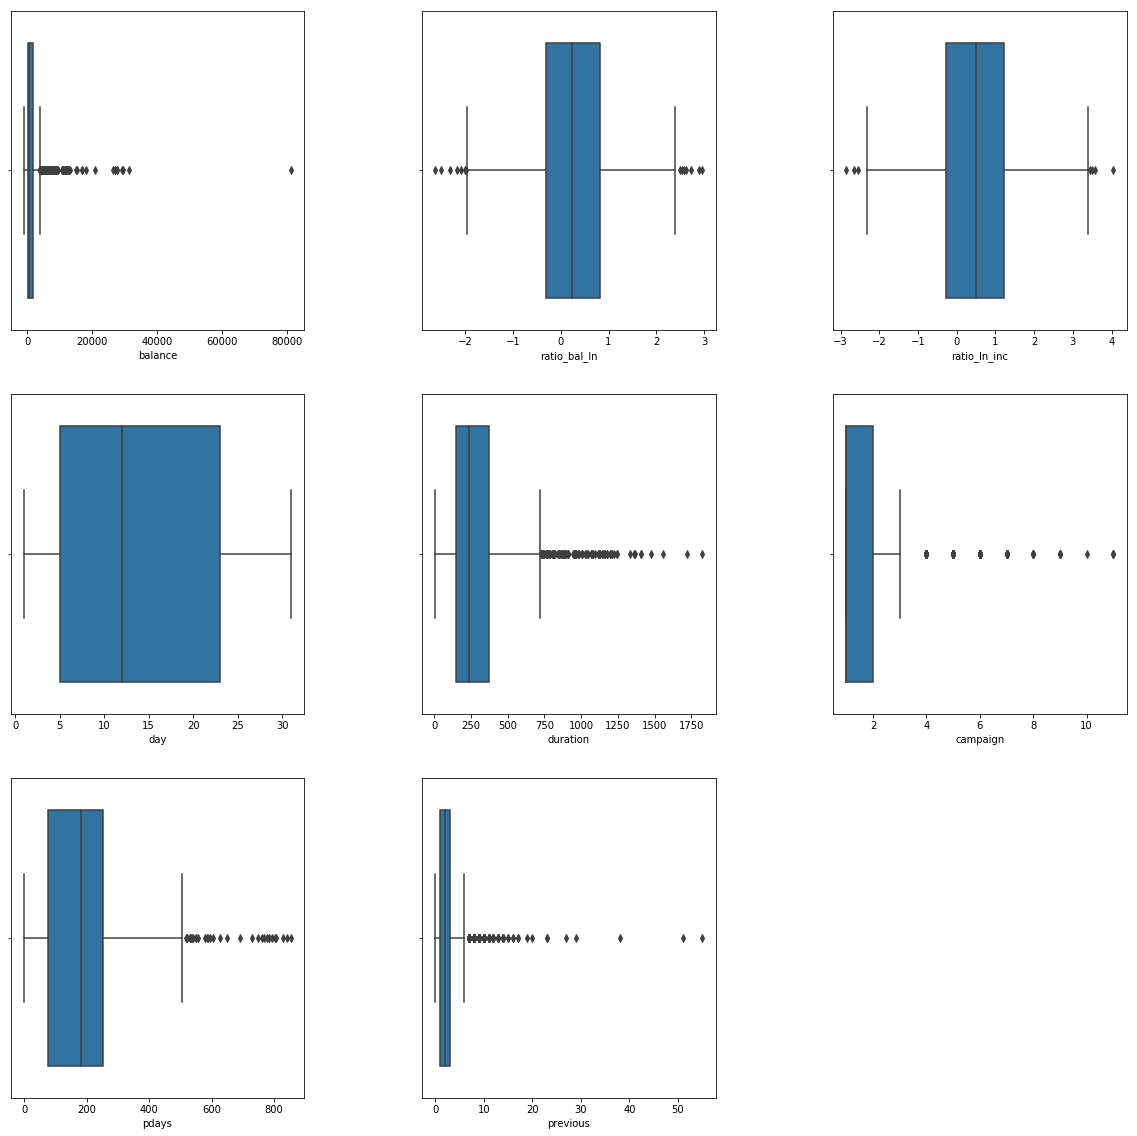

In [25]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.2, wspace=0.4)
for i in range(1, numerics_df.shape[1]):
    plt.subplot(numerics_df.shape[1]/3, numerics_df.shape[1]/3, i)
    sns.boxplot(x=numerics_df.iloc[:,i])
    


Outliers are mostly represented by points out of the box (the Q1-Q3 range), these are the points we have to manage and remove from our data. to do that we will use the Inter Quartile Range (IQR) which is the difference between 75th and 25th percentiles. We will calculate this statistique in a first time and then remove data points that are above or under this value with a predefined treshold. We will choose a reasonable treshold of 4 for this task, so only very far points from Q1/Q3 will be removed and hence we will avoid to remove some coorect data erroneously

In [26]:
Q1 = numerics_df.quantile(0.25)
Q3 = numerics_df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

age               18.000000
balance         1435.750000
ratio_bal_ln       1.115552
ratio_ln_inc       1.486669
day               18.000000
duration         229.750000
campaign           1.000000
pdays            174.750000
previous           2.000000
dtype: float64


In [27]:
print(numerics_df.shape)
treshold=4
numerics_df =  numerics_df[~(( numerics_df < (Q1 - treshold * IQR)) |( numerics_df > (Q3 + treshold * IQR))).any(axis=1)]
print(numerics_df.shape)

(1990, 9)
(1864, 9)


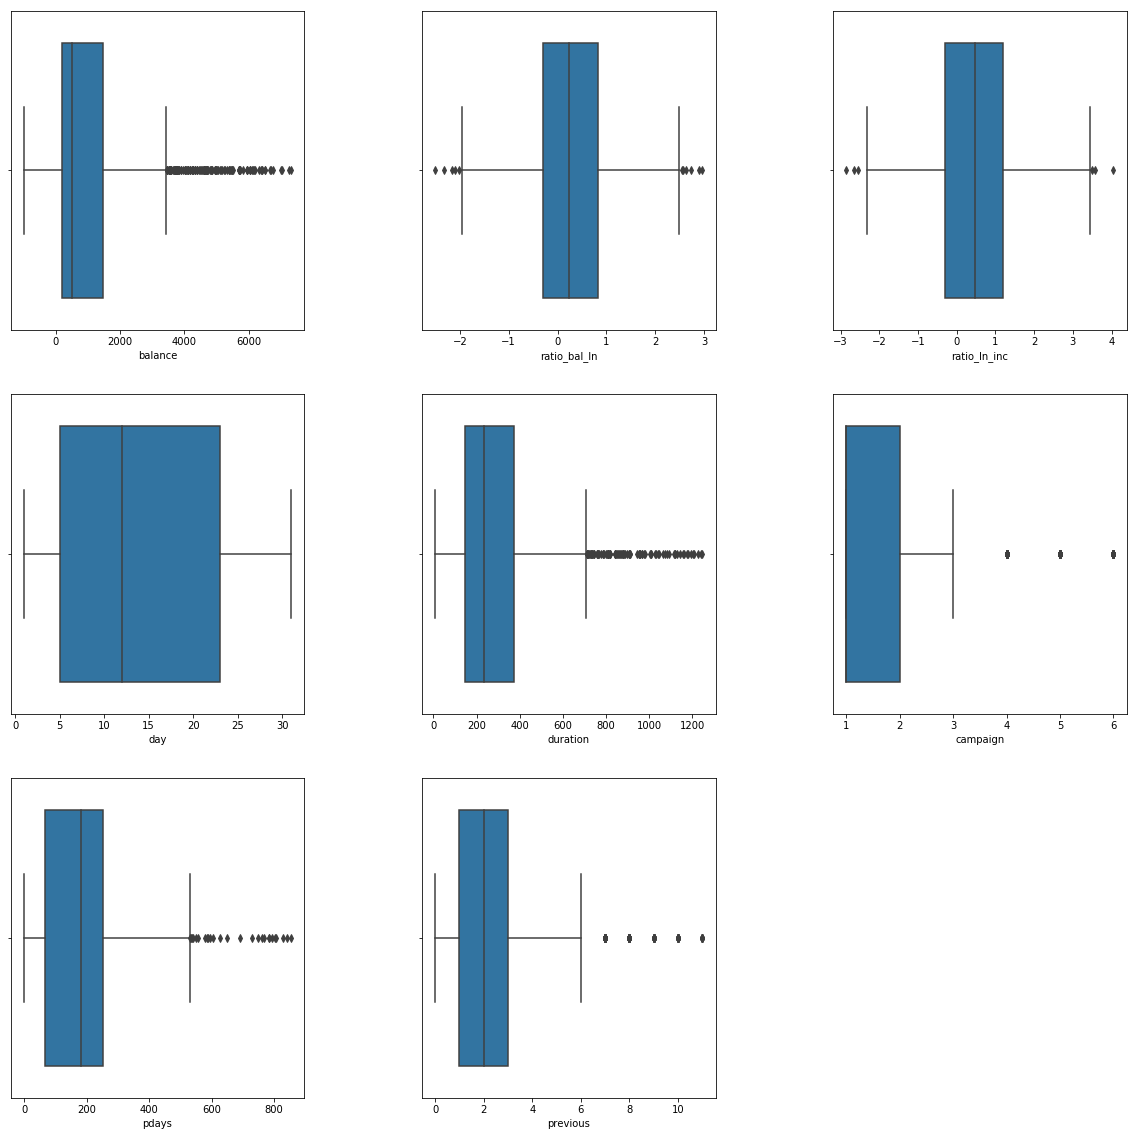

In [28]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.2, wspace=0.4)
for i in range(1, numerics_df.shape[1]):
    plt.subplot(numerics_df.shape[1]/3, numerics_df.shape[1]/3, i)
    sns.boxplot(x=numerics_df.iloc[:,i])
    

We see that even if we still have some points out of the IQR Box, we nomore having isolated data points as before removing outliers

#### Back to our DF

In [29]:
#Get indexes of numerics_df, so we can select these rows from original df
outliers_indexes=numerics_df.index


print("Original number of rows: %5d" % df.shape[0])
df=df.loc[outliers_indexes.values,:]#only rows without outliers are selected
print('number of rows after outliers removal: %5d' % df.shape[0])


Original number of rows:  1990
number of rows after outliers removal:  1864


In [30]:
df.head(20)#verifying row 9 was removed

,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,32.0,technician,single,tertiary,no,392,1.300134,0.473895,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,39.0,technician,divorced,secondary,no,688,-0.193701,0.237021,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,59.0,retired,married,secondary,no,1035,1.334266,0.121981,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,47.0,blue-collar,married,secondary,no,398,0.362286,1.251328,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,54.0,retired,married,secondary,no,1004,0.072075,-0.533738,yes,no,cellular,1,apr,479,1,307,1,failure,no
5,46.0,self-employed,divorced,tertiary,no,926,0.233619,0.922197,yes,no,cellular,1,apr,463,1,133,3,failure,no
6,34.0,blue-collar,married,secondary,no,1924,0.022648,0.724227,yes,yes,cellular,1,apr,161,2,253,1,failure,no
7,45.0,services,divorced,secondary,no,396,-0.724889,-0.998605,yes,yes,cellular,1,apr,251,4,329,4,failure,no
8,58.0,management,divorced,tertiary,no,315,0.502131,-0.045391,yes,no,cellular,1,apr,121,2,135,2,failure,no
10,38.0,management,single,secondary,no,715,1.079459,-1.642914,yes,no,cellular,2,apr,951,1,132,3,failure,no


# Task 3

#### We create two features based on Job and month features since these latters got a big number of categories. 

In [31]:
#Combining entrepreneurs and self-employed into self-employed
df.job.replace(['entrepreneur', 'self-employed'], 'self-employed', inplace=True)
#Combining administrative and management jobs into admin_management
df.job.replace(['admin.', 'management'], 'administration_management', inplace=True)
#Combining blue-collar and tecnician jobs into blue-collar
df.job.replace(['blue-collar', 'technician'], 'blue-collar', inplace=True)
#Combining retired and unemployed into no_active_income
df.job.replace(['retired', 'unemployed'], 'no_active_income', inplace=True)
#Combining services and housemaid into services
df.job.replace(['services', 'housemaid'], 'services', inplace=True)

df.job=df.job.astype('category')

#Winter
df.month.replace(['dec', 'jan','feb'], 'Winter', inplace=True)
#Spring
df.month.replace(['mar', 'apr','may'], 'Spring', inplace=True)
#Summer
df.month.replace(['jun', 'jul','aug'], 'Summer', inplace=True)
#Autumn
df.month.replace(['sep', 'oct','nov'], 'Autumn', inplace=True)


df.month=df.month.astype('category')

# Task 4

#### default feature will be dropped as we've seen in EDA step that 99% didn' have default

In [32]:
df.drop("default",axis=1,inplace=True)

#### Additionaly we need to convert our target feature to a 0/1 numerical variable :

In [33]:
#Substituting the string predictor variable values with numbers
df.subscribed.replace(['yes'], 1, inplace=True)
df.subscribed.replace(['no'], 0, inplace=True)

### Logistic regression

#### Creating dummy variables

In [34]:
cat_vars=df.select_dtypes(include='category')
for column in cat_vars:
    cat_list='var'+'_'+column
    cat_list = pd.get_dummies(df[column], prefix=column, drop_first=True)
    df1=df.join(cat_list)
    df=df1
df_vars=df.columns.values.tolist()
to_keep=[i for i in df_vars if i not in cat_vars]

df_final=df[to_keep]
df_final.columns.values

array(['age', 'balance', 'ratio_bal_ln', 'ratio_ln_inc', 'day',
       'duration', 'campaign', 'pdays', 'previous', 'subscribed',
       'job_blue-collar', 'job_no_active_income', 'job_self-employed',
       'job_services', 'job_student', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'housing_yes',
       'loan_yes', 'contact_telephone', 'month_Spring', 'month_Summer',
       'month_Winter', 'poutcome_no_previous', 'poutcome_other',
       'poutcome_success'], dtype=object)

In [35]:
X = df_final.loc[:, df_final.columns != 'subscribed']
y = df_final.loc[:, df_final.columns == 'subscribed']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. 

In [37]:
logreg = LogisticRegression(solver='liblinear')
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_train, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False False  True  True  True False False False  True  True  True  True
  True  True False  True  True False  True  True  True  True  True  True
  True  True  True]
[5 8 1 1 1 6 2 7 1 1 1 1 1 1 3 1 1 4 1 1 1 1 1 1 1 1 1]


In [38]:
selected=rfe.support_.tolist()

#Getting indexes of selected features
indexes=[]
for i in range(len(selected)):
    if selected[i]==True:
        indexes.append(i)


print('Selected features are :') 
print(X_train.columns.values[indexes])

Selected features are :
['ratio_bal_ln' 'ratio_ln_inc' 'day' 'previous' 'job_blue-collar'
 'job_no_active_income' 'job_self-employed' 'job_services' 'job_student'
 'marital_single' 'education_secondary' 'housing_yes' 'loan_yes'
 'contact_telephone' 'month_Spring' 'month_Summer' 'month_Winter'
 'poutcome_no_previous' 'poutcome_other' 'poutcome_success']


In [39]:
#Retreiving selected features from train columns
X=X_train.loc[:,X_train.columns[indexes]]
X_test=X_test.loc[:,X_test.columns[indexes]]
X.head()

,ratio_bal_ln,ratio_ln_inc,day,previous,job_blue-collar,job_no_active_income,job_self-employed,job_services,job_student,marital_single,education_secondary,housing_yes,loan_yes,contact_telephone,month_Spring,month_Summer,month_Winter,poutcome_no_previous,poutcome_other,poutcome_success
221,0.901097,0.916247,3,4,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0
1375,0.765979,0.077770,27,4,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1
1560,0.026581,0.960954,31,3,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
61,-0.664496,1.649806,1,1,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0
1984,-0.169010,1.775916,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


#### Implementing the model

In [40]:
#statsmodels is used in order to get pvalues and coefficients
logit_model=sm.Logit(y_train.values,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.087059
         Iterations 34


LinAlgError: Singular matrix

#### To see why the error above is raised, we fit the model on selected features one by one and see when exactly the problem occurs. And it seems that month_Summer is  causing some problem to the model, let's check it

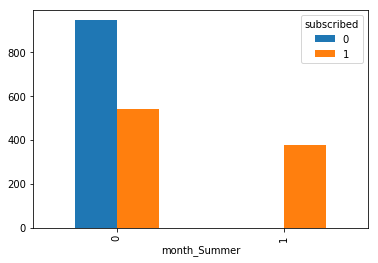

In [44]:
pd.crosstab(df_final.month_Summer,df_final.subscribed).plot(kind='bar')


#### All Customers contacted in Summer have subscribed, this may cause some problem for the model, maybe quasi-separability problem, so we will delete this feature from the model

In [45]:
X_noSummer=X.drop('month_Summer',axis=1)
X_test_noSummer=X_test.drop('month_Summer',axis=1)#We have to drop it also from X_test since we will do prediction on this sample
logit_model=sm.Logit(y_train.values,X_noSummer)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.099974
         Iterations 10
                           Results: Logit
Model:                 Logit             Pseudo R-squared:  0.856   
Dependent Variable:    y                 AIC:               298.7318
Date:                  2019-02-12 23:16  BIC:               397.0224
No. Observations:      1304              Log-Likelihood:    -130.37 
Df Model:              18                LL-Null:           -903.81 
Df Residuals:          1285              LLR p-value:       0.0000  
Converged:             1.0000            Scale:             1.0000  
No. Iterations:        10.0000                                      
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
ratio_bal_ln         -1.7077   0.2640 -6.4673 0.0000 -2.2252 -1.1901
ratio_ln_inc          1.289

#### So now the model is converging and we get many significant p_values

#### Now We Will **Fit the model** with 

In [46]:
logreg.fit(X_noSummer, y_train.values.ravel())


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [47]:
y_pred = logreg.predict(X_test_noSummer)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_noSummer, y_test)))

Accuracy of logistic regression classifier on test set: 0.93


In [48]:
Confusion_matrix = confusion_matrix(y_test, y_pred)
print('confusion matrix')
print(pd.DataFrame(Confusion_matrix))
print('\n classification report ')
print(classification_report(y_test, y_pred))

confusion matrix
     0    1
0  268   18
1   20  254

 classification report 
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       286
           1       0.93      0.93      0.93       274

   micro avg       0.93      0.93      0.93       560
   macro avg       0.93      0.93      0.93       560
weighted avg       0.93      0.93      0.93       560



### Very good results both for 0's and 1's as we obtain 93% good predictions

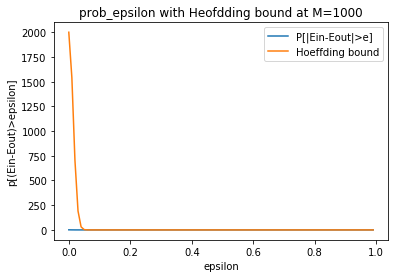

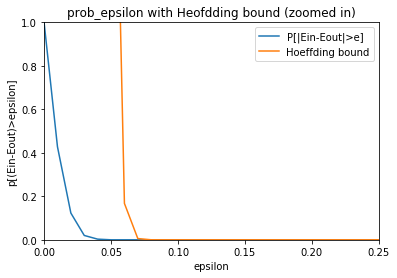

In [49]:
def Errors(M):
    Ein=[] #Empty list that will contain all obtained Eins
    Eout=[] #Same for Eouts
    
    m=0
    for m in range(M):
        X = df_final.loc[:, df_final.columns != 'subscribed'] 
        y = df_final.loc[:, df_final.columns == 'subscribed'] 
        
        rand_state=random.randint(1,500) #we generate a new random_state for each iteration, so the result of the 
                                         #train_test_split will be different in each iteration
        
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=rand_state)#generating the train and test sets
        
        X=X_train.loc[:,X_train.columns[indexes]]     #Here we just use the selected futures
        X_test=X_test.loc[:,X_test.columns[indexes]]  #same for test data as we did before
        X_noSummer=X.drop('month_Summer',axis=1)      #as seen before, we drop month_Summer 
        X_test_noSummer=X_test.drop('month_Summer',axis=1)
        
        logreg.fit(X_noSummer, y_train.values.ravel()) #Logistic regression is fitted
        
        errorin=1-logreg.score(X_noSummer, y_train.values.ravel()) #Calculating the Errorin (train error): thats 1-Accuracy score
        errorout=1-logreg.score(X_test_noSummer, y_test) #Calculating test error wich estimates Eout
        
        Ein.append(errorin)   #add the obtained Ein in the current iteration to the Ein list
        Eout.append(errorout) #Same for Eout
        m=+1
    

    #Here we want to calculate the left hand side of the Hoeffding's Inequality (the Probability that errors differences exceeding Epsilon)
    prob_e=[]  #Empty list that will contain different probabilities/rates
    es = np.arange(0, 1, 0.01) # range of Epsilons
    for e in es: 
        counter = 0
        for i in range(M):
            if abs(Ein[i] - Eout[i])>e:
                   counter +=1 # we count how many times the difference exceeds Epsilon
        prob_e.append(counter/M)  #the proability is estimated by the rate of times exceeding Epsilon out of total M tries 
       
        
        
    
    N = len(X) #total train size
    
    plt.figure()
    plt.plot(es, prob_e, label='P[|Ein-Eout|>e]')   
    plt.plot(es, [2*M*math.exp(-2*e**2*N) for e in es], label="Hoeffding bound") #right hand side of the Hoeffding's inequality
    #VC bound gives a Huge number, python is not able to handle it
    #plt.plot(es, [4*(2**(2*N))*math.exp((-1/8)*e**2*N) for e in es], label="Hoeffding bound") #right hand side of the VC's inequality

    plt.xlabel('epsilon')
    plt.ylabel('p[(Ein-Eout)>epsilon]')
    plt.title('prob_epsilon with Heofdding bound at M=%d' % M)
    plt.legend(loc='upper right')
    plt.show    
    #return {"Eins":Ein, "Eouts":Eout,"Epsilons":es,"Prob Epsilon":prob_e}
    
    
    
          
    plt.figure()
    plt.plot(es, prob_e, label='P[|Ein-Eout|>e]')
    plt.plot(es, [2*M*math.exp(-2*e**2*N) for e in es], label="Hoeffding bound")
          
    axes = plt.gca()
    axes.set_xlim([0,0.25])
    axes.set_ylim([0,1])

    plt.xlabel('epsilon')
    plt.ylabel('p[(Ein-Eout)>epsilon]')
    plt.title('prob_epsilon with Heofdding bound (zoomed in)')
    plt.legend(loc='upper right')
    plt.show

      

Errors(1000)


### Hopefully Learning Feasibility is ensure here as the Probability of the differences between Ein and Eout don't exceed the Hoeffding's bound even for M=1000.

# Task 5

#### Inspired by https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

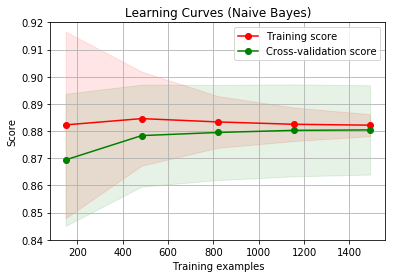

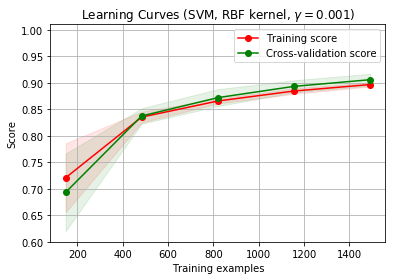

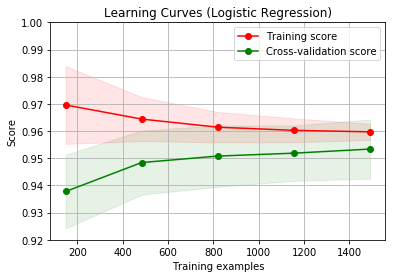

In [50]:


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


X = df_final.loc[:, df_final.columns != 'subscribed']
X=X.loc[:,X.columns[indexes]]
X_noSummer=X.drop('month_Summer',axis=1)
y = df_final.loc[:, df_final.columns == 'subscribed']





title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.84, 0.92), cv=cv, n_jobs=4)

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.6, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (Logistic Regression)"

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LogisticRegression(solver='liblinear')
plot_learning_curve(estimator, title, X, y, (0.92, 1), cv=cv, n_jobs=4)

plt.show()

#### Comparing the logistic regression with the SVM model, Logistic regression is getting better score for either Ein (approximation) or Eout compared to SVM resuls (0.96 Vs 0.90), Logistic regression seems to be the more complex model regarding the highest approximation score. In the other hand, about the generalization ability which is the discrepancy between Ein and Eout curves, this difference is much smaller or even null for SVM compared with Logistic one, so this less complex model is better when talking about generalization. It also seems that SVM gets better and better with more data examples, which is not the case of Logistic regression.